# Main Project


*   Adalat Adiljan
*   Daniela Márquez Campos



In [ ]:
!pip install ultralytics albumentations opencv-python-headless pillow kaggle matplotlib seaborn

In [ ]:
# I've just downloaded random libraries incase we need them (not sure if we will use them all)
from ultralytics import YOLO # Yolo implementation
from google.colab import files
import tensorflow as tf
import torch
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical computations
import os                        # For operating system dependent functionality
import sys                       # For system-specific parameters and functions
import glob
import cv2                       # OpenCV for image processing
#import kaggle                    # To download datasets from Kaggle
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.metrics import (                         # For evaluating models
    accuracy_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import requests
import random
from IPython.display import display, Image

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
# !unzip brain-tumor-mri-dataset.zip -d dataset

In [ ]:
# drive.mount('/content/drive') // To save output

## Dowloading dataset directly of Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="TAX1vlKQkZlLxzpgmTsu")
project = rf.workspace("mri-brain-tumor-detection").project("brain_tumor_detect")
version = project.version(6)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


## Visualizing the dataset (in process)

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h, *_ = bbox_string.split(' ') # Here I added *_ include all the elements in the "bbox" that were missing, but It might not be necessary (as it might affect the F1 score)
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

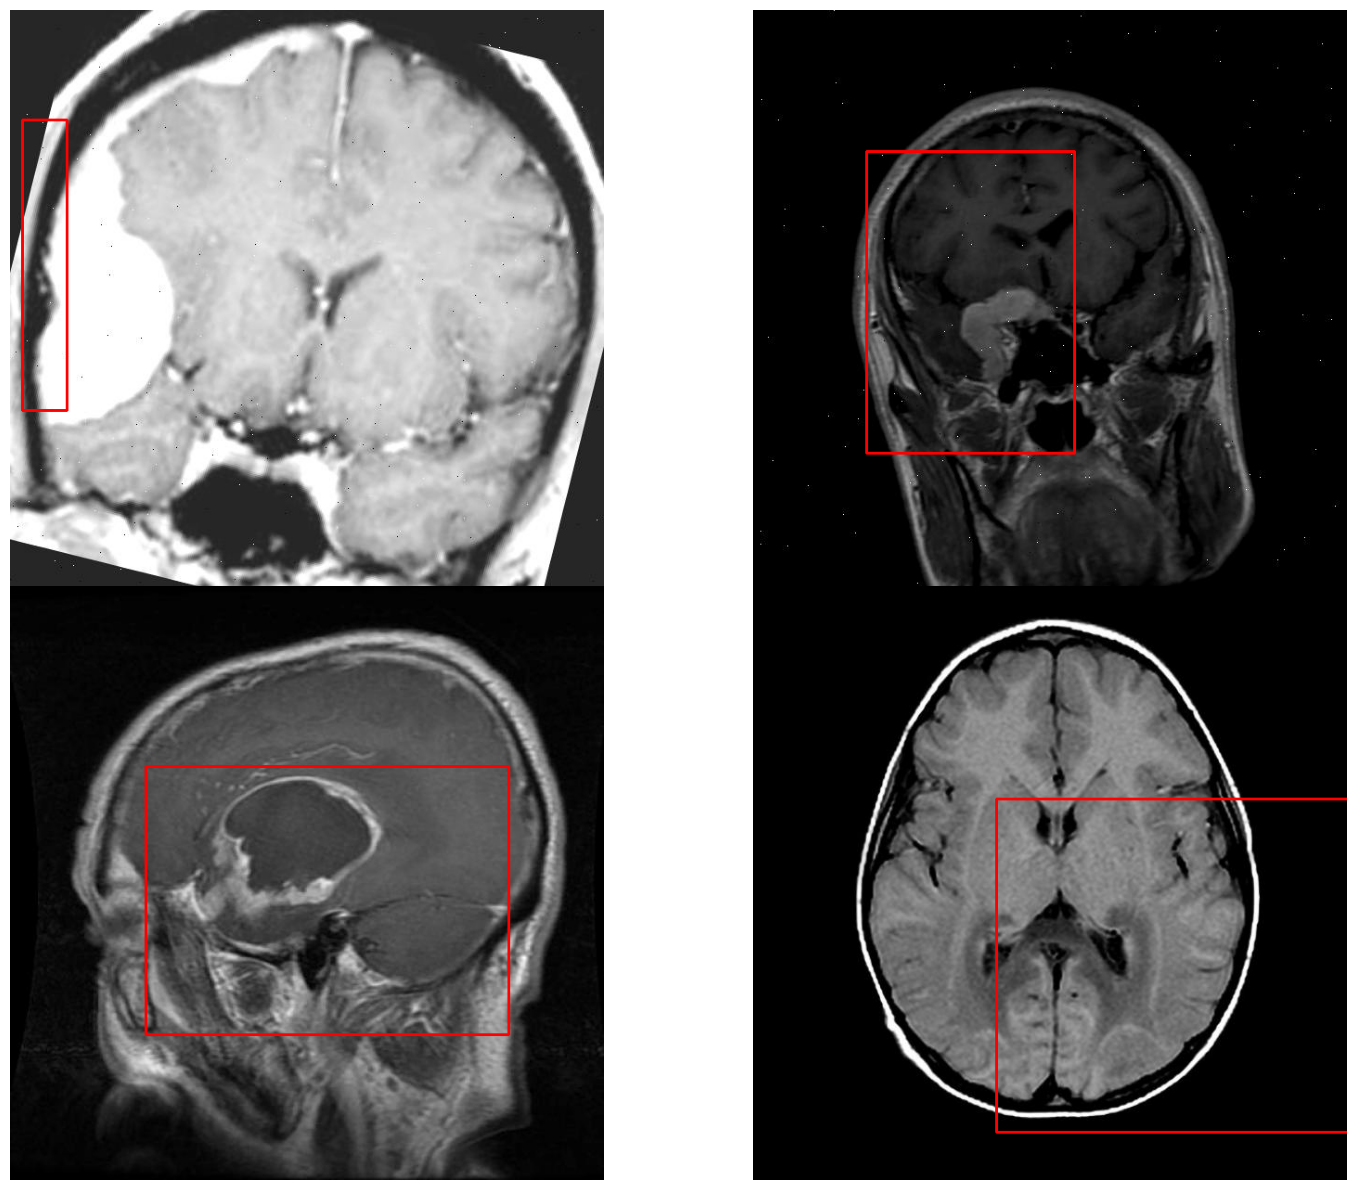

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/Brain_Tumor_Detect-6/train/images',
    label_paths='/content/Brain_Tumor_Detect-6/train/labels',
    num_samples=4,
)

## Fine-tuning the YOLO8m pre-trained model

In [ ]:
# Setting hyperparameters
epochs = 5
batch = 8
imag_size = 1280

In [ ]:
# Actual Fine-tuning process

# Loading the pre-trained model
model = YOLO('yolov8m.pt')

# Fine-tuning
results = model.train(
    data='/content/Brain_Tumor_Detect-6/data.yaml',
    epochs=epochs,
    imgsz=imag_size,
    batch=batch,
    name = 'BTD_8m_1')

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/Brain_Tumor_Detect-6/data.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=BTD_8m_15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /content/Brain_Tumor_Detect-6/train/labels.cache... 6024 images, 3 backgrounds, 0 corrupt: 100%|██████████| 6024/6024 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Brain_Tumor_Detect-6/valid/labels.cache... 574 images, 1 backgrounds, 0 corrupt: 100%|██████████| 574/574 [00:00<?, ?it/s]


Plotting labels to runs/detect/BTD_8m_15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/detect/BTD_8m_15
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      15.6G      1.332      2.815      1.685         15       1280: 100%|██████████| 753/753 [12:36<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:26<00:00,  1.35it/s]

                   all        574        594       0.38      0.391       0.34      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      15.6G      1.326      1.838      1.673         12       1280: 100%|██████████| 753/753 [12:27<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.42it/s]

                   all        574        594      0.561      0.571      0.565       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      15.4G      1.194      1.588      1.562         13       1280: 100%|██████████| 753/753 [12:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.41it/s]

                   all        574        594       0.59      0.587      0.562      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      15.4G      1.123      1.392        1.5         19       1280: 100%|██████████| 753/753 [12:23<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.42it/s]

                   all        574        594      0.655      0.647      0.664      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      15.4G     0.9931      1.184      1.412         18       1280: 100%|██████████| 753/753 [12:23<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:25<00:00,  1.42it/s]

                   all        574        594      0.679      0.726      0.706      0.436



5 epochs completed in 1.077 hours.
Optimizer stripped from runs/detect/BTD_8m_15/weights/last.pt, 52.2MB
Optimizer stripped from runs/detect/BTD_8m_15/weights/best.pt, 52.2MB

Validating runs/detect/BTD_8m_15/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:24<00:00,  1.44it/s]


                   all        574        594      0.679      0.725      0.706      0.436
          Glioma_Tumor        174        189       0.65      0.589      0.628      0.432
      Meningioma_Tumor        182        185      0.854      0.778      0.861      0.697
              No_Tumor         68         69      0.555      0.797       0.65      0.228
       Pituitary_Tumor        149        151      0.657      0.736      0.685      0.389
Speed: 0.7ms preprocess, 38.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/BTD_8m_15


## Validation of the obtained model

In [ ]:
# Load the best model for evaluation and validation
model = YOLO('runs/detect/BTD_8m_15/weights/best.pt')

# Validate the model
val_results = model.val(
    data='/content/Brain_Tumor_Detect-6/data.yaml',
    name='BTD_8m_1_eval')


Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/Brain_Tumor_Detect-6/valid/labels.cache... 574 images, 1 backgrounds, 0 corrupt: 100%|██████████| 574/574 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:55<00:00,  1.53s/it]


                   all        574        594      0.678      0.724      0.705      0.436
          Glioma_Tumor        174        189      0.648      0.587      0.627      0.431
      Meningioma_Tumor        182        185      0.854      0.778      0.861      0.697
              No_Tumor         68         69      0.555      0.794      0.649      0.227
       Pituitary_Tumor        149        151      0.657      0.735      0.684       0.39
Speed: 0.9ms preprocess, 89.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/BTD_8m_1_eval


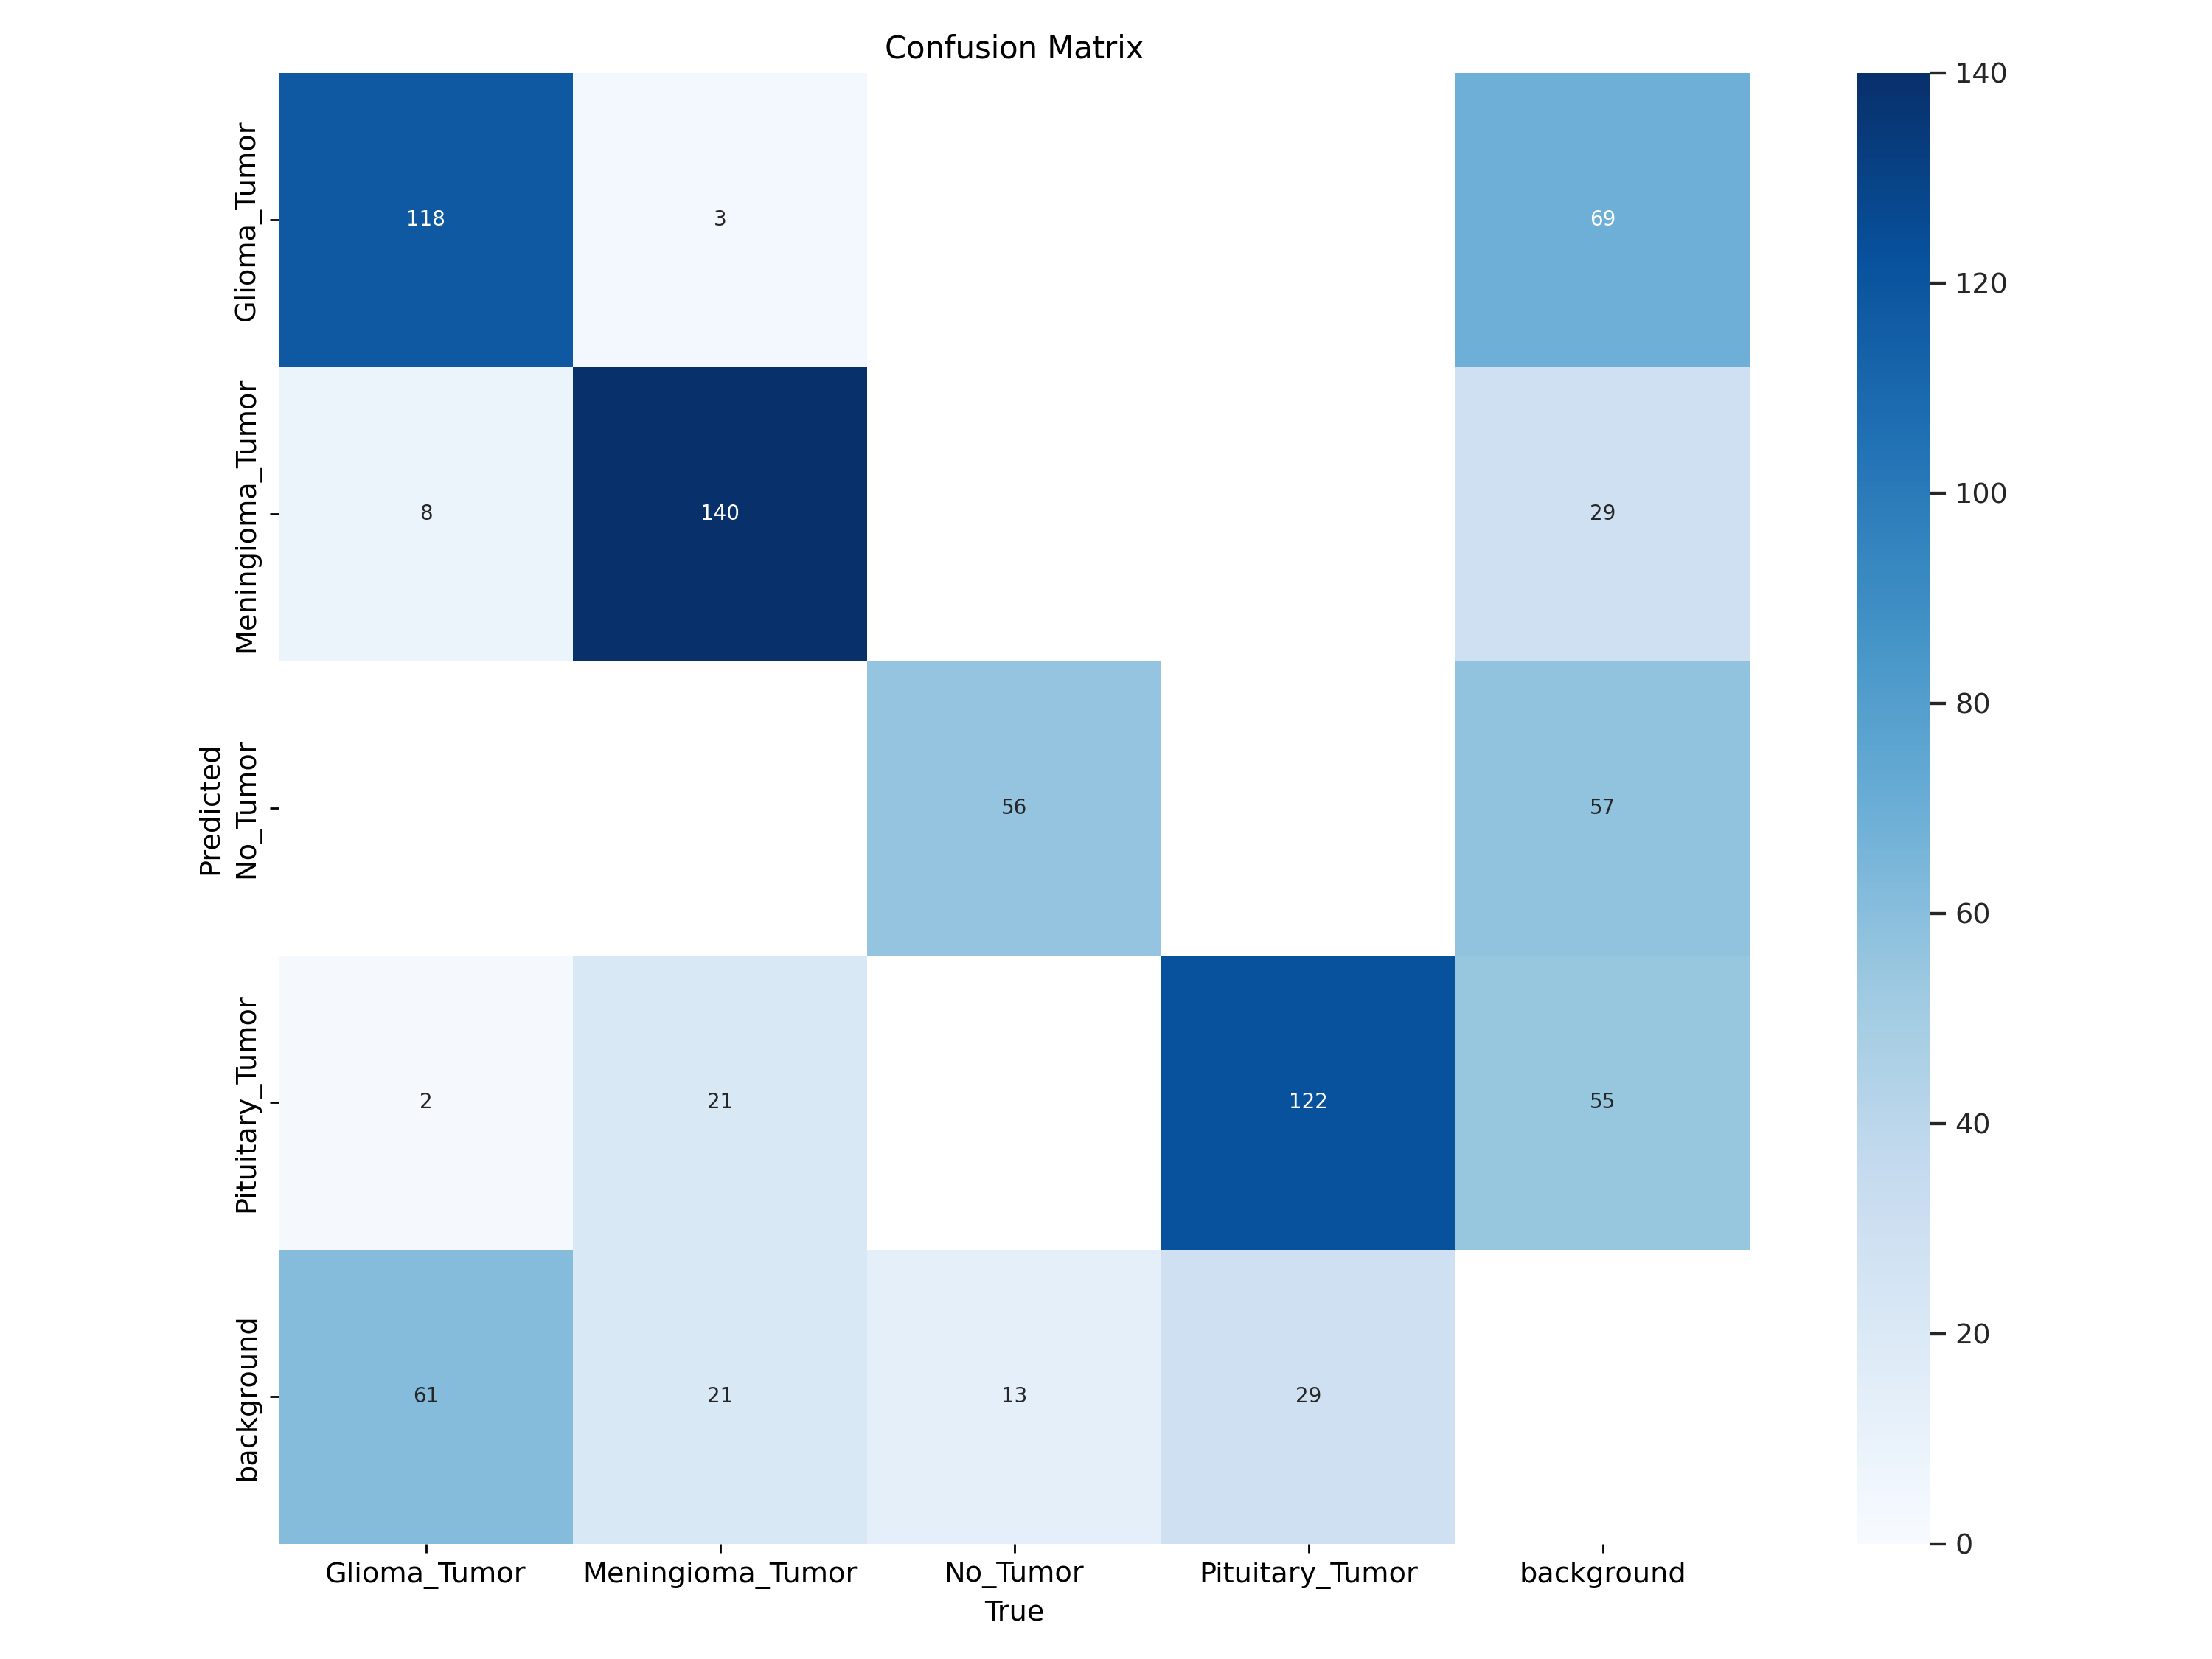

In [ ]:
# Confusion matrix of the validation
Image('/content/runs/detect/BTD_8m_1_eval/confusion_matrix.png', width=600)

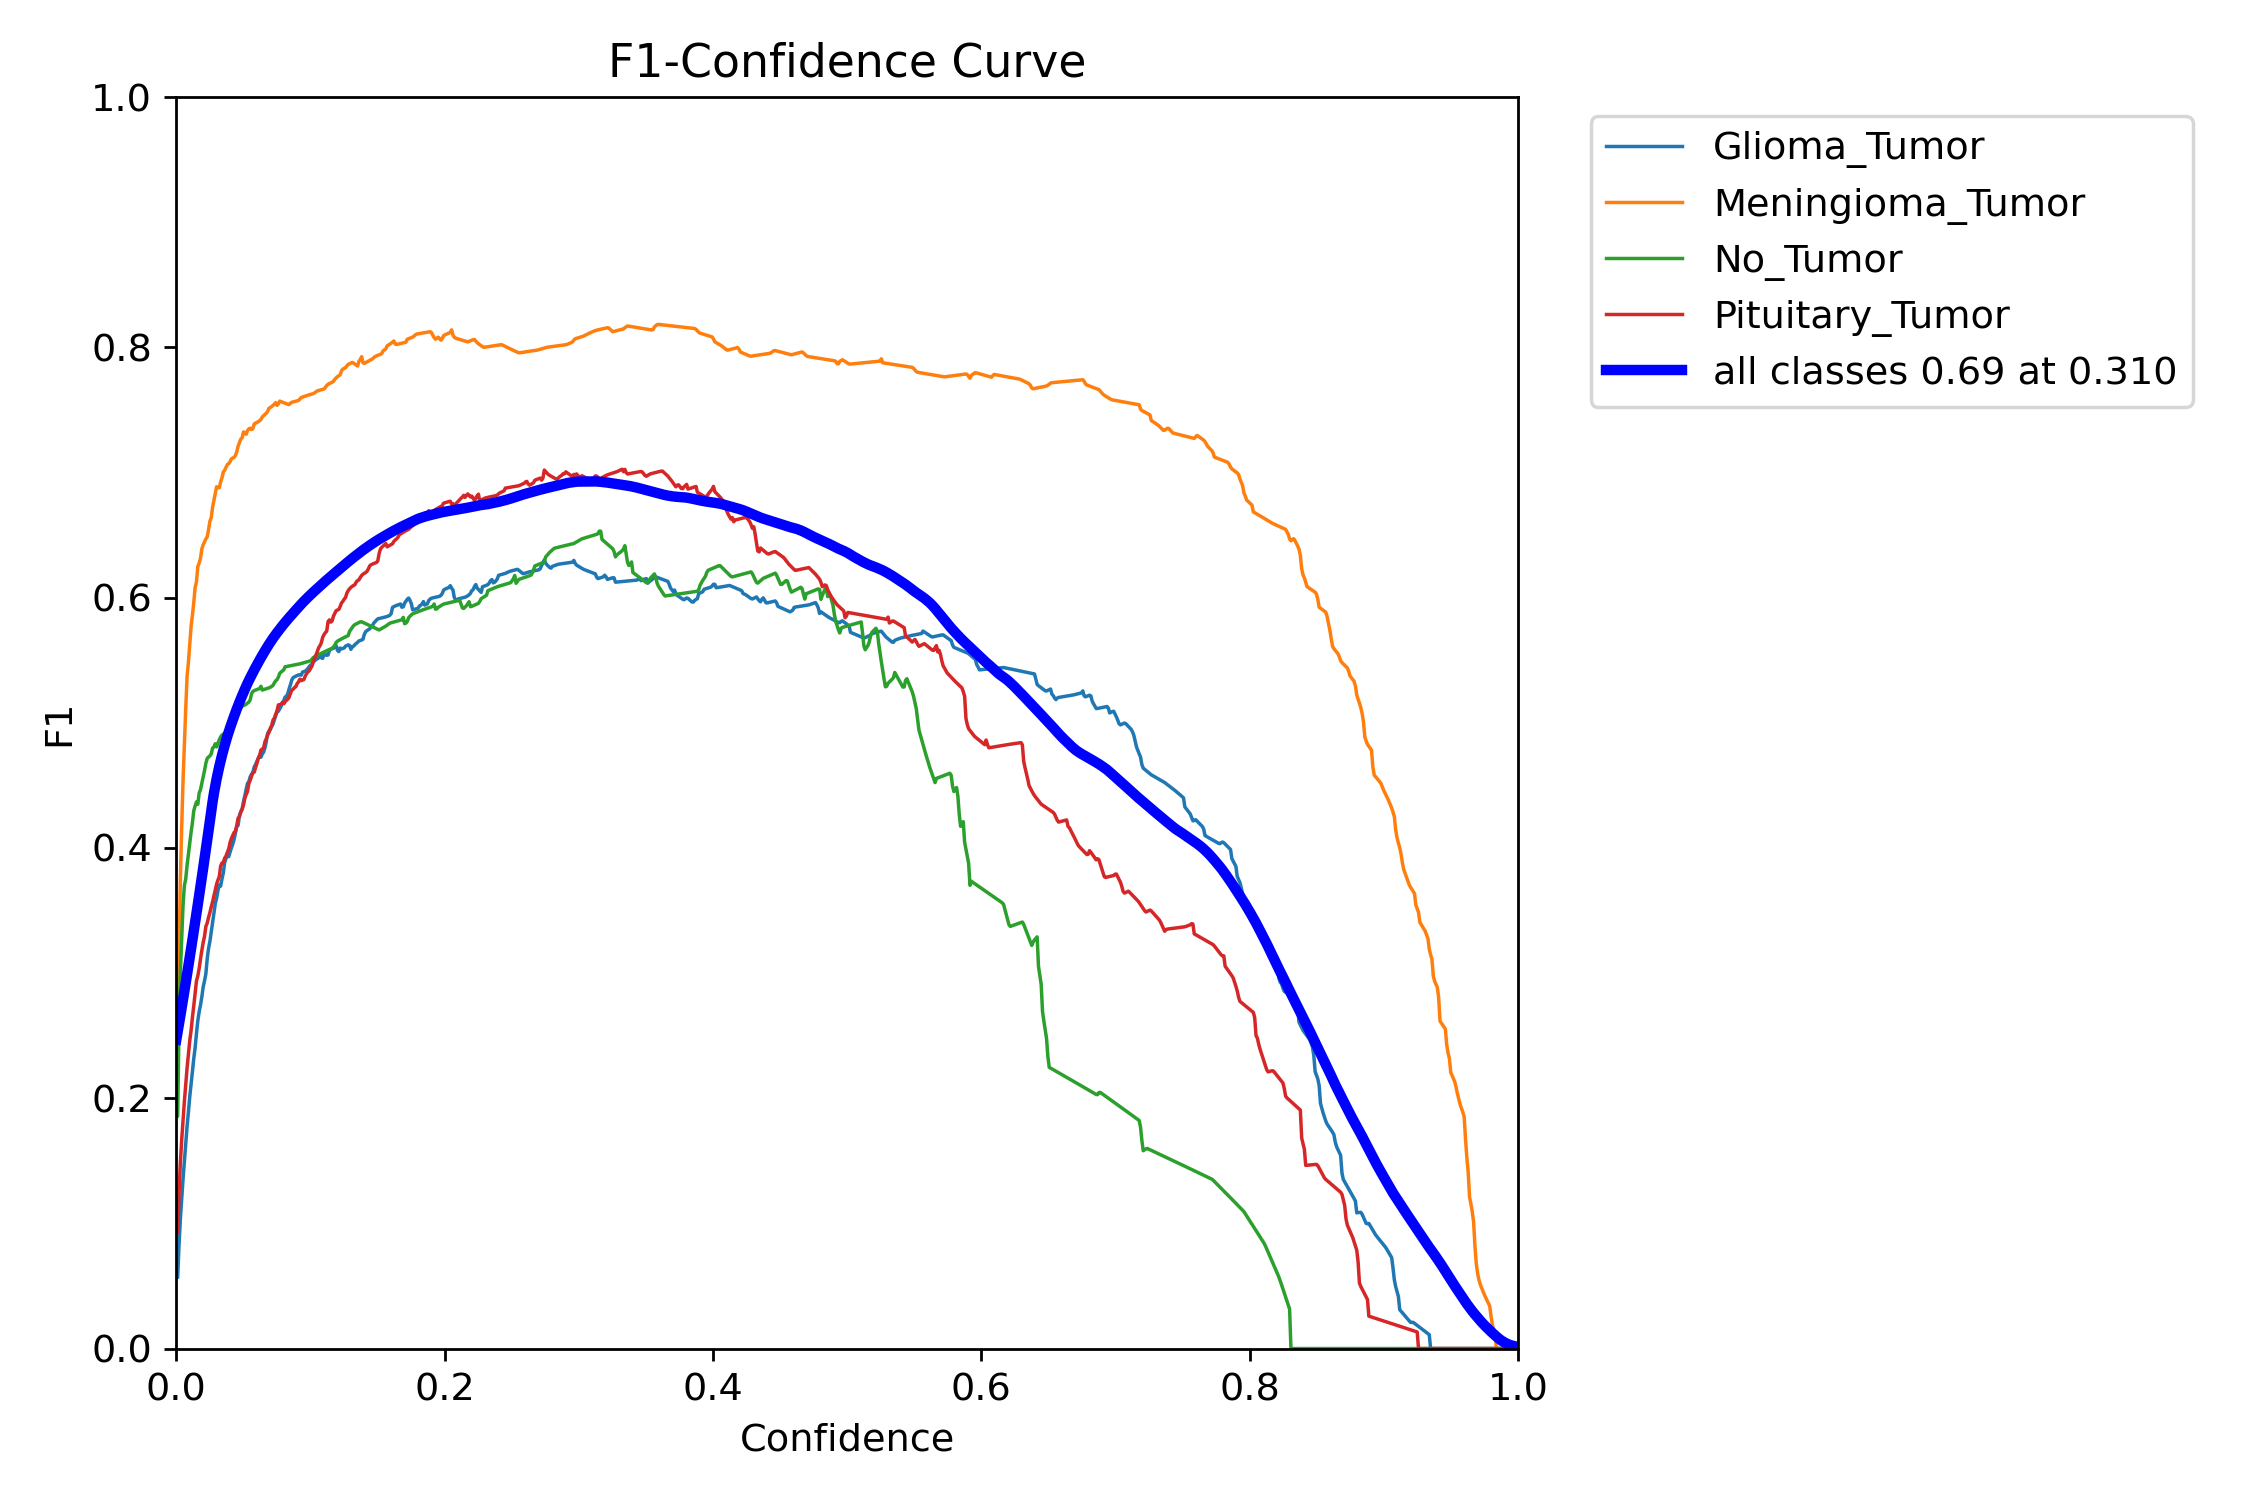

In [ ]:
# F1 score of the validation
Image('/content/runs/detect/BTD_8m_1_eval/F1_curve.png', width=600)

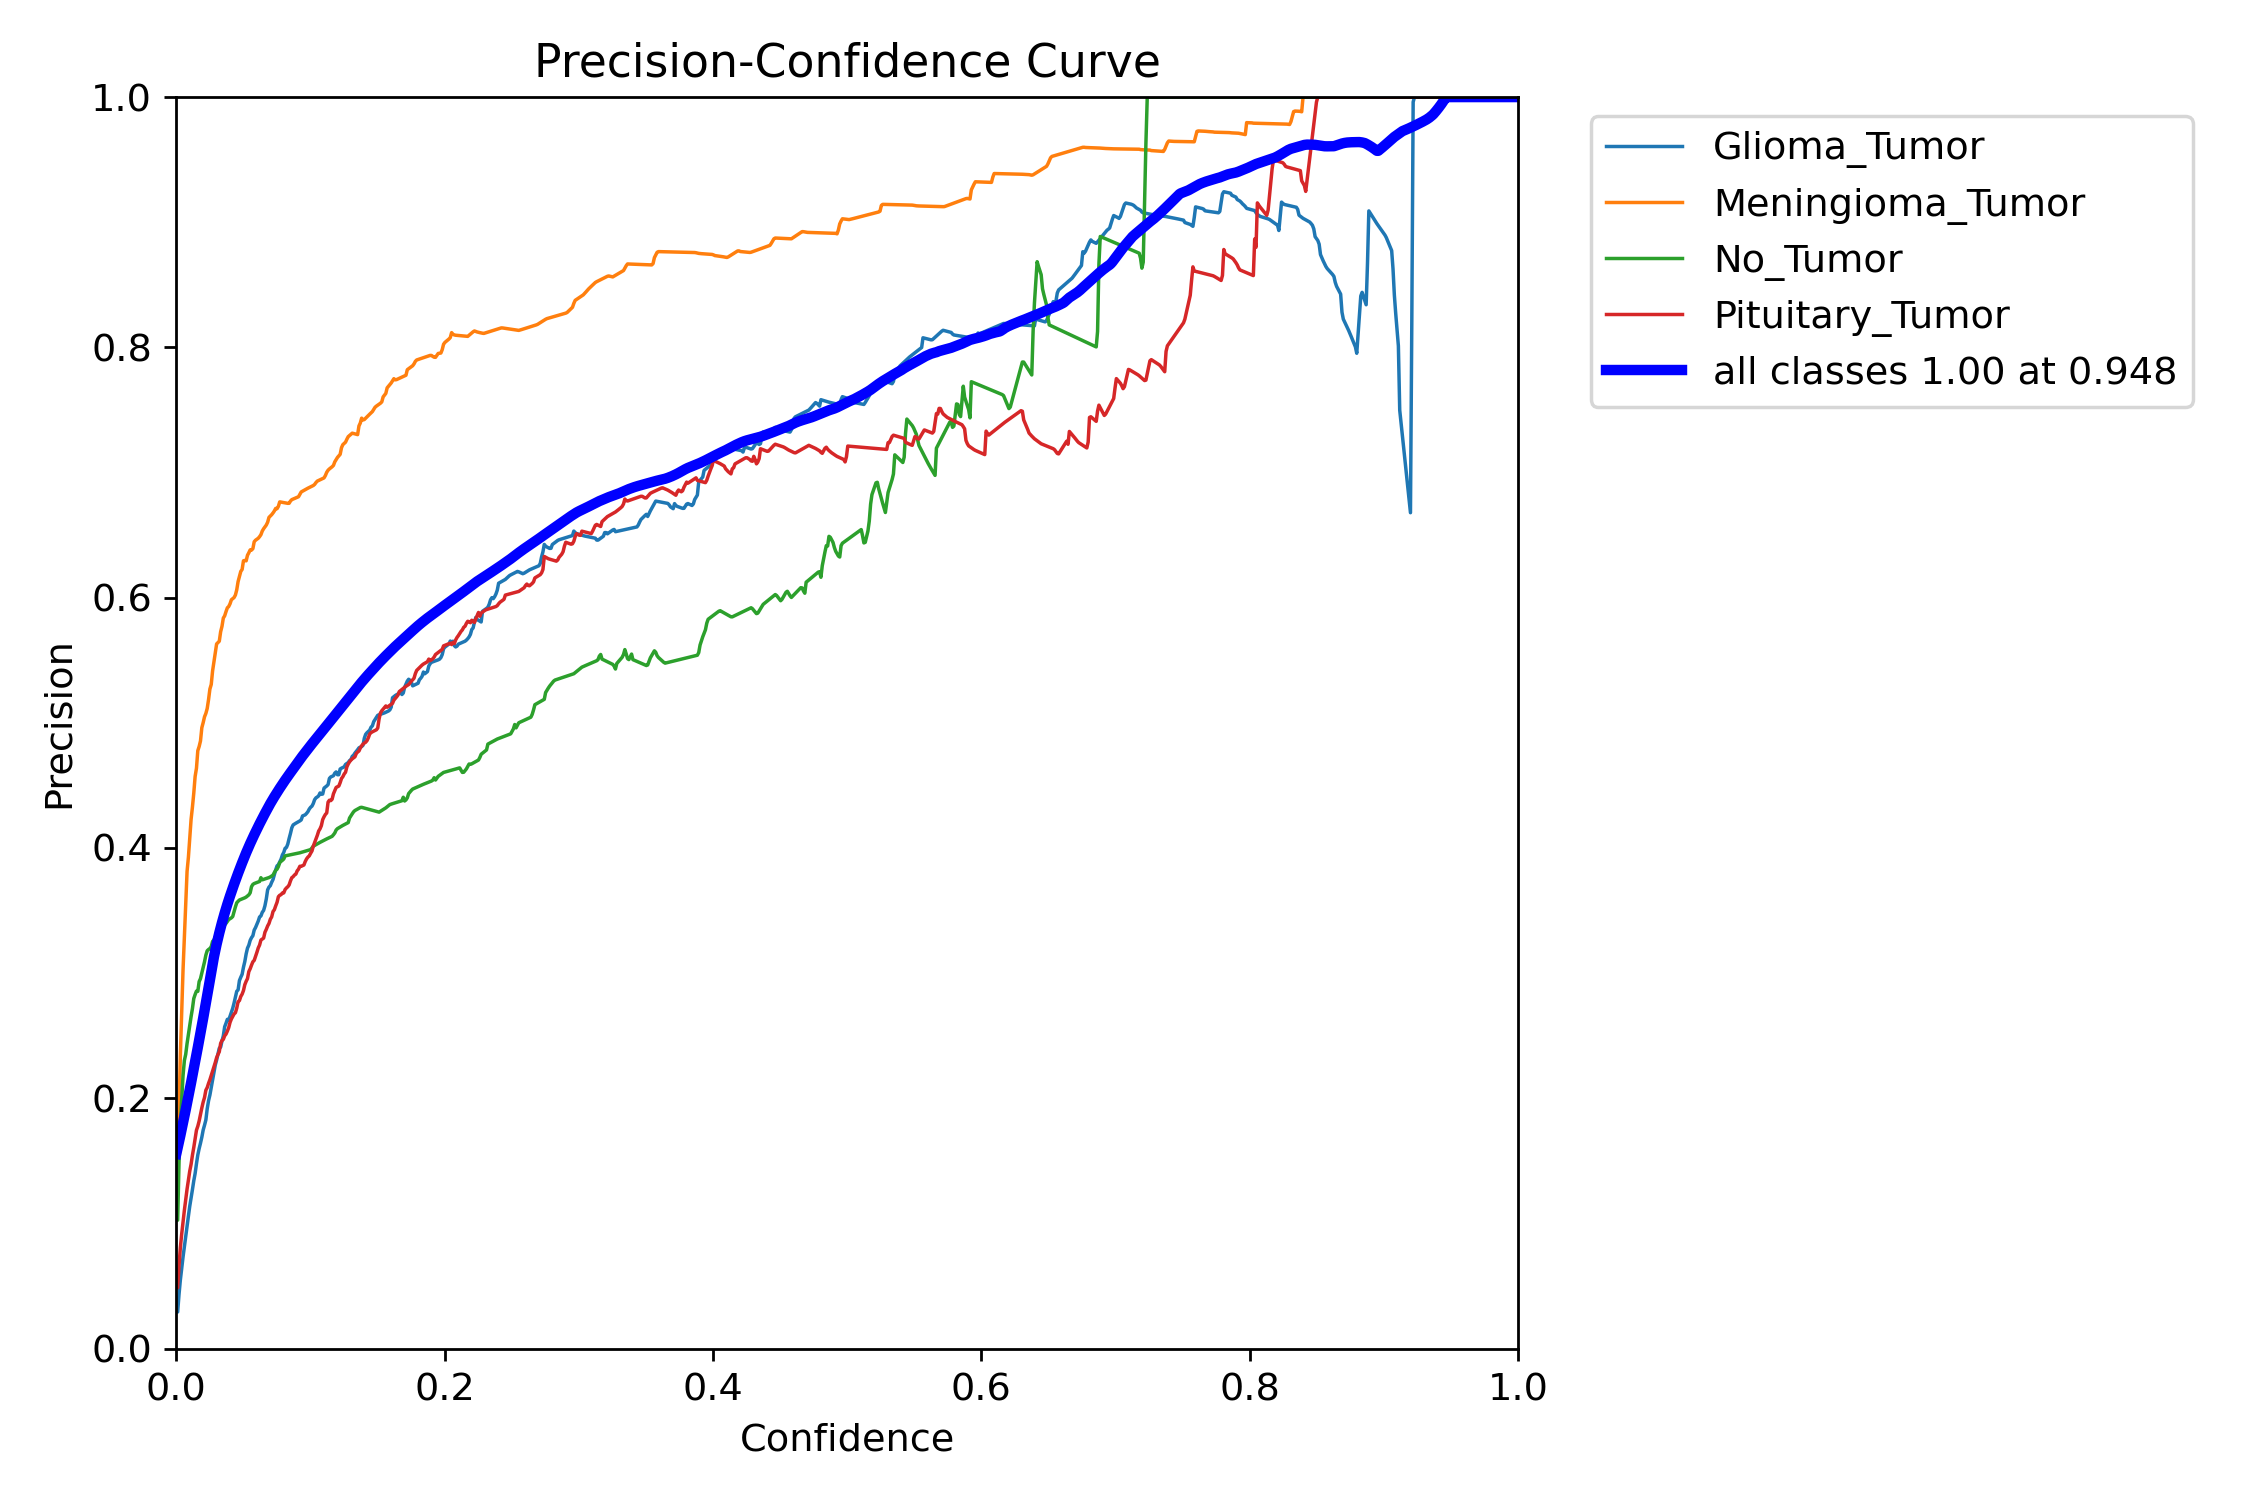

In [ ]:
from IPython.display import Image

# Display Precision-Recall curve
Image('/content/runs/detect/BTD_8m_1_eval/PR_curve.png', width=600)

## Inference with the obtained model

In [ ]:
# Loading the best model for prediction

model = YOLO('runs/detect/BTD_8m_15/weights/best.pt')

# Predicing with the model
pred_results = model.predict(
    data='/content/Brain_Tumor_Detect-6/data.yaml',
    name='BTD_8m_1_pred',
    source="/content/Brain_Tumor_Detect-6/test/images",  # Path to the test images
    conf=0.7,                                # Confidence threshold
    save=True                                 # Save the predictions to the default runs directory
)


image 1/288 /content/Brain_Tumor_Detect-6/test/images/2_jpg.rf.4b862834c0551fb440aa212fa9c467df.jpg: 1280x1280 (no detections), 98.2ms
image 2/288 /content/Brain_Tumor_Detect-6/test/images/3_jpg.rf.2c48d1ccbd32b2c0ac7086a914b6e807.jpg: 1280x1280 (no detections), 77.7ms
image 3/288 /content/Brain_Tumor_Detect-6/test/images/gg-121-_jpg.rf.6af1296dd89578c181644816b63e6cac.jpg: 1280x1280 (no detections), 77.4ms
image 4/288 /content/Brain_Tumor_Detect-6/test/images/gg-128-_jpg.rf.4e084c41d6cf55508842b5a3cfa2f33b.jpg: 1280x1280 (no detections), 76.0ms
image 5/288 /content/Brain_Tumor_Detect-6/test/images/gg-145-_jpg.rf.a0fcb9c426b7c15cbc1befd0d85750b5.jpg: 1280x1280 (no detections), 77.5ms
image 6/288 /content/Brain_Tumor_Detect-6/test/images/gg-151-_jpg.rf.b14d14ce27b888b64396fc929c16b7d8.jpg: 1280x1280 1 Glioma_Tumor, 76.5ms
image 7/288 /content/Brain_Tumor_Detect-6/test/images/gg-170-_jpg.rf.9ad1ae17e519d35e62606db2c93de819.jpg: 1280x1280 (no detections), 76.7ms
image 8/288 /content/Brai

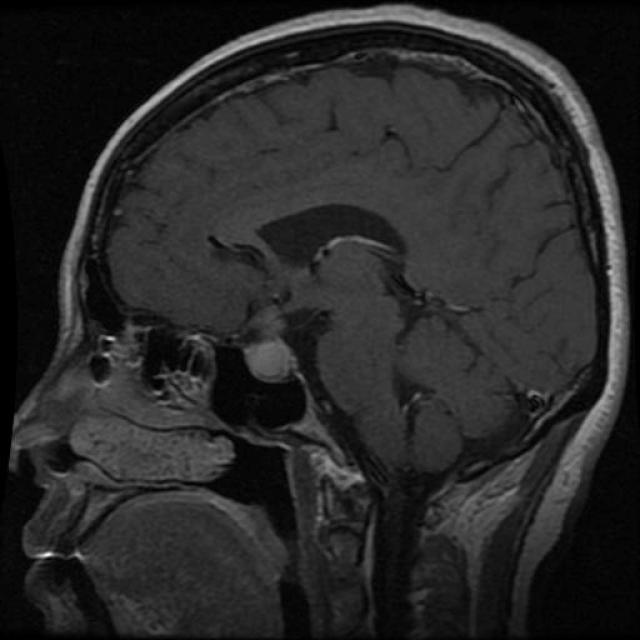

In [ ]:
# Defining the folder with all the predicted images
pred_folder = '/content/runs/detect/BTD_8m_1_pred2'

image_paths = glob.glob(f'{pred_folder}/*.jpg')[1:2]

# Displaying an image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")

In [ ]:
import os
from collections import Counter

In [ ]:
# Path to YOLO label files (training labels)
label_path = '/content/Brain_Tumor_Detect-6/train/labels/'

# Counter to track occurrences of each tumor class
class_counts = Counter()

# Loop through each label file
for file in os.listdir(label_path):
    if file.endswith('.txt'):  # Process only .txt label files
        with open(os.path.join(label_path, file), 'r') as f:
            for line in f:
                class_id = line.split(' ')[0]  # Extract class_id (first value)
                class_counts[class_id] += 1

# Print the class distribution
print("Tumor Class Distribution (From YOLO Labels):")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count}")

Tumor Class Distribution (From YOLO Labels):
Class 3: 1751
Class 1: 1776
Class 0: 1992
Class 2: 729


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Second Model instance, attempt to improve the F1 score for the tuning**

In [ ]:
model2 = YOLO('yolov8m.pt')

In [ ]:
# Attempt 2 on Fine-tuning the model, where a new instance of the Yolo model called "model2" was created to avoid the risk of overfitting
results2 = model2.train(
    data='/content/Brain_Tumor_Detect-6/data.yaml',
    epochs=5,
    batch=6,
    imgsz=1280,
    augment=True,
    fliplr=0.5, # Enable horizontal flip
    degrees=10, # Random rotation (small angle)
    translate=0.1, # Random translation
    hsv_v=0.4, # Add random brightness (value) changes
    hsv_s=0.7, # Add random saturation changes
    save=True,
    name='train8', # New name for this experiment
    exist_ok=True
)

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/Brain_Tumor_Detect-6/data.yaml, epochs=5, time=None, patience=100, batch=6, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning /content/Brain_Tumor_Detect-6/train/labels.cache... 6024 images, 3 backgrounds, 0 corrupt: 100%|██████████| 6024/6024 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Brain_Tumor_Detect-6/valid/labels.cache... 574 images, 1 backgrounds, 0 corrupt: 100%|██████████| 574/574 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.000515625), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/detect/train8
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      15.3G      1.377      2.845      1.775          8       1280: 100%|██████████| 1004/1004 [12:49<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]

                   all        574        594      0.537      0.218      0.268      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.8G      1.371      1.948      1.771         15       1280: 100%|██████████| 1004/1004 [12:38<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]

                   all        574        594      0.522      0.562      0.493      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.2G      1.245      1.676      1.648         17       1280: 100%|██████████| 1004/1004 [12:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]

                   all        574        594      0.669      0.607      0.621      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.2G      1.134      1.458      1.556          9       1280: 100%|██████████| 1004/1004 [12:35<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]

                   all        574        594      0.668      0.672      0.701      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.2G      1.024      1.236      1.452         16       1280: 100%|██████████| 1004/1004 [12:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]

                   all        574        594      0.678      0.719      0.719      0.443



5 epochs completed in 1.127 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 52.2MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 52.2MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:55<00:00,  1.16s/it]


                   all        574        594      0.737       0.76      0.788      0.603
          Glioma_Tumor        174        189      0.653      0.593      0.628      0.437
      Meningioma_Tumor        182        185      0.852       0.87      0.896      0.737
              No_Tumor         68         69      0.676      0.928      0.905      0.822
       Pituitary_Tumor        149        151      0.766      0.649      0.723      0.414
Speed: 0.7ms preprocess, 92.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train8


In [1]:
from ultralytics import YOLO

# Load the first model for evaluation and validation
model2 = YOLO('runs/detect/train8/weights/best.pt')

# Save model2 to Google Drive
model2_saved = '/content/drive/MyDrive/ID1214-Project/best_model2.pt'
model2.save(model2_saved)  # Save the model


ModuleNotFoundError: No module named 'ultralytics'

In [2]:
from ultralytics import YOLO
import torch
model2.to('cpu')

# Perform predictions on the test images
pred_results2 = model2.predict(
    data='/content/Brain_Tumor_Detect-6/data.yaml',
    name='model2_pred',                              # Name for saving prediction results
    source="/content/Brain_Tumor_Detect-6/test/images",
    conf=0.7,
    save=True,  # Save the predictions to the default runs directory
    imgsz=640,
)

ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
# Defining the folder with all the predicted images
pred_folder = '/content/runs/detect/model2_pred'

image_paths = glob.glob(f'{pred_folder}/*.jpg')[1:2]

# Displaying an image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")

In [ ]:
pred_results = model2.predict(
    data='/content/Brain_Tumor_Detect-6/data.yaml',
    source='/content/Brain_Tumor_Detect-6/test/images',
    conf=0.8,  # Confidence threshold
    save=True,
    name='test_predictions_model2'
)

In [ ]:
results = model2.val(data='/content/Brain_Tumor_Detect-6/data.yaml')

In [ ]:

from IPython.display import Image

# True performance for running the validation set:
Image('/content/runs/detect/val/F1_curve.png', width=600)

In [ ]:
# Attempt 3 on trying with different parameters to further improve the F1 score, with different parameters this time:
results3 = model2.train(
    data='/content/Brain_Tumor_Detect-6/data.yaml',  # Same dataset
    epochs=5,
    batch=6,
    lr0=0.001,           # Adjusted learning rate
    weight_decay=0.0005, # Added L2 regularization
    save=True,           # Save the updated model
    name='train9',       # New experiment name
    exist_ok=True        # Allow overwriting if needed
)